In [ ]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 导入数据集
data = np.loadtxt('sindata_1000.csv', delimiter=',')
num_data = len(data)
split = int(num_data * 0.8)
print("数据集大小:", num_data)
print("训练集大小:", split)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(split), data[:split], color='blue', label='training data')
plt.plot(np.arange(split, num_data), data[split:], color='red', label='test data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 分割数据集
train_data = data[:split]
test_data = data[split:]

# --- 修正数据准备逻辑 ---
seq_length = 20

def create_sequences(input_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:(i + seq_length)]
        y = input_data[i + seq_length]  # 目标是预测下一个点
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# 设置随机数种子
np.random.seed(0)
torch.manual_seed(0)

# 数据转化为张量并增加特征维度
x_train = torch.from_numpy(x_train).to(torch.float32).unsqueeze(-1) # (N, seq_len, 1)
y_train = torch.from_numpy(y_train).to(torch.float32).unsqueeze(-1) # (N, 1)
x_test = torch.from_numpy(x_test).to(torch.float32).unsqueeze(-1)
y_test = torch.from_numpy(y_test).to(torch.float32).unsqueeze(-1)

# 定义GRU模型
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.linear(out[:, -1, :]) # 只取最后一个时间步的输出
        return out, hidden

# 设置超参数
input_size = 1
output_size = 1
hidden_size = 64
num_layers = 2 # 使用多层GRU
learning_rate = 1e-3
batch_size = 16
num_epochs = 50

# 创建DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# 初始化网络
gru = GRU(input_size, output_size, hidden_size, num_layers)
gru_optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# 训练GRU模型
print("开始训练GRU模型...")
for epoch in range(num_epochs):
    gru.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        hidden = None # 每个batch重新初始化hidden
        output, hidden = gru(x_batch, hidden)
        loss = loss_fn(output, y_batch)
        
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()
        
        total_loss += loss.item()
        
    if (epoch + 1) % 10 == 0:
        print(f"GRU Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}")

# 对比测试 MLP模型
mlp = nn.Sequential(
    nn.Linear(seq_length, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size // 2),
    nn.ReLU(),
    nn.Linear(hidden_size // 2, output_size)
)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# 训练MLP模型
print("\n开始训练MLP模型...")
# MLP的输入需要是2D的
x_train_mlp = x_train.squeeze(-1)
y_train_mlp = y_train
mlp_train_dataset = TensorDataset(x_train_mlp, y_train_mlp)
mlp_train_loader = DataLoader(mlp_train_dataset, shuffle=True, batch_size=batch_size)

for epoch in range(num_epochs):
    mlp.train()
    total_loss = 0
    for x_batch, y_batch in mlp_train_loader:
        output = mlp(x_batch)
        loss = loss_fn(output, y_batch)
        mlp_optimizer.zero_grad()
        loss.backward()
        mlp_optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"MLP Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(mlp_train_loader):.6f}")

# --- 修正测试逻辑 ---
def predict(model, initial_input):
    model.eval()
    predictions = []
    current_input = initial_input.clone() # (1, seq_len, 1) or (1, seq_len)
    with torch.no_grad():
        for _ in range(len(x_test)):
            if isinstance(model, GRU):
                pred, _ = model(current_input, None)
                predictions.append(pred.item())
                # 更新输入序列: 移除第一个点，加入预测的点
                next_step = pred.unsqueeze(0) # (1, 1, 1)
                current_input = torch.cat((current_input[:, 1:, :], next_step), dim=1)
            else: # MLP
                pred = model(current_input)
                predictions.append(pred.item())
                next_step = pred
                current_input = torch.cat((current_input[:, 1:], next_step), dim=1)
    return predictions

# 获取初始序列进行预测
gru_preds = predict(gru, x_train[0].unsqueeze(0))
mlp_preds = predict(mlp, x_train.squeeze(-1)[0].unsqueeze(0))

# 绘制预测结果
plt.figure(figsize=(15, 7))
# 真实测试数据从split点开始
test_time_steps = np.arange(split, num_data)
plt.plot(test_time_steps, data[split:], label='True Data', color='black', linewidth=2)
# 预测数据也从split点开始
plt.plot(test_time_steps, gru_preds, label='GRU Prediction', color='red', linestyle='--')
plt.plot(test_time_steps, mlp_preds, label='MLP Prediction', color='green', linestyle=':')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.title('GRU vs MLP Prediction on Test Data')
plt.grid(True)
plt.show()
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 导入数据集
data = np.loadtxt('sindata_1000.csv', delimiter=',')
num_data = len(data)
split = int(num_data * 0.8)
print("数据集大小:", num_data)
print("训练集大小:", split)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(split), data[:split], color='blue', label='training data')
plt.plot(np.arange(split, num_data), data[split:], color='red', label='test data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 分割数据集
train_data = data[:split]
test_data = data[split:]

# --- 修正数据准备逻辑 ---
seq_length = 20

def create_sequences(input_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:(i + seq_length)]
        y = input_data[i + seq_length]  # 目标是预测下一个点
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# 设置随机数种子
np.random.seed(0)
torch.manual_seed(0)

# 数据转化为张量并增加特征维度
x_train = torch.from_numpy(x_train).to(torch.float32).unsqueeze(-1) # (N, seq_len, 1)
y_train = torch.from_numpy(y_train).to(torch.float32).unsqueeze(-1) # (N, 1)
x_test = torch.from_numpy(x_test).to(torch.float32).unsqueeze(-1)
y_test = torch.from_numpy(y_test).to(torch.float32).unsqueeze(-1)

# 定义GRU模型
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.linear(out[:, -1, :]) # 只取最后一个时间步的输出
        return out, hidden

# 设置超参数
input_size = 1
output_size = 1
hidden_size = 64
num_layers = 2 # 使用多层GRU
learning_rate = 1e-3
batch_size = 16
num_epochs = 50

# 创建DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# 初始化网络
gru = GRU(input_size, output_size, hidden_size, num_layers)
gru_optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# 训练GRU模型
print("开始训练GRU模型...")
for epoch in range(num_epochs):
    gru.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        hidden = None # 每个batch重新初始化hidden
        output, hidden = gru(x_batch, hidden)
        loss = loss_fn(output, y_batch)
        
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()
        
        total_loss += loss.item()
        
    if (epoch + 1) % 10 == 0:
        print(f"GRU Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}")

# 对比测试 MLP模型
mlp = nn.Sequential(
    nn.Linear(seq_length, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size // 2),
    nn.ReLU(),
    nn.Linear(hidden_size // 2, output_size)
)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# 训练MLP模型
print("\n开始训练MLP模型...")
# MLP的输入需要是2D的
x_train_mlp = x_train.squeeze(-1)
y_train_mlp = y_train
mlp_train_dataset = TensorDataset(x_train_mlp, y_train_mlp)
mlp_train_loader = DataLoader(mlp_train_dataset, shuffle=True, batch_size=batch_size)

for epoch in range(num_epochs):
    mlp.train()
    total_loss = 0
    for x_batch, y_batch in mlp_train_loader:
        output = mlp(x_batch)
        loss = loss_fn(output, y_batch)
        mlp_optimizer.zero_grad()
        loss.backward()
        mlp_optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"MLP Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(mlp_train_loader):.6f}")

# --- 修正测试逻辑 ---
def predict(model, initial_input):
    model.eval()
    predictions = []
    current_input = initial_input.clone() # (1, seq_len, 1) or (1, seq_len)
    with torch.no_grad():
        for _ in range(len(x_test)):
            if isinstance(model, GRU):
                pred, _ = model(current_input, None)
                predictions.append(pred.item())
                # 更新输入序列: 移除第一个点，加入预测的点
                next_step = pred.unsqueeze(0) # (1, 1, 1)
                current_input = torch.cat((current_input[:, 1:, :], next_step), dim=1)
            else: # MLP
                pred = model(current_input)
                predictions.append(pred.item())
                next_step = pred
                current_input = torch.cat((current_input[:, 1:], next_step), dim=1)
    return predictions

# 获取初始序列进行预测
gru_preds = predict(gru, x_train[0].unsqueeze(0))
mlp_preds = predict(mlp, x_train.squeeze(-1)[0].unsqueeze(0))

# 绘制预测结果
plt.figure(figsize=(15, 7))
# 真实测试数据从split点开始
test_time_steps = np.arange(split, num_data)
plt.plot(test_time_steps, data[split:], label='True Data', color='black', linewidth=2)
# 预测数据也从split点开始
plt.plot(test_time_steps, gru_preds, label='GRU Prediction', color='red', linestyle='--')
plt.plot(test_time_steps, mlp_preds, label='MLP Prediction', color='green', linestyle=':')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.title('GRU vs MLP Prediction on Test Data')
plt.grid(True)
plt.show()

SyntaxError: invalid syntax (1748186197.py, line 170)

数据集大小: 1000
训练集大小: 800


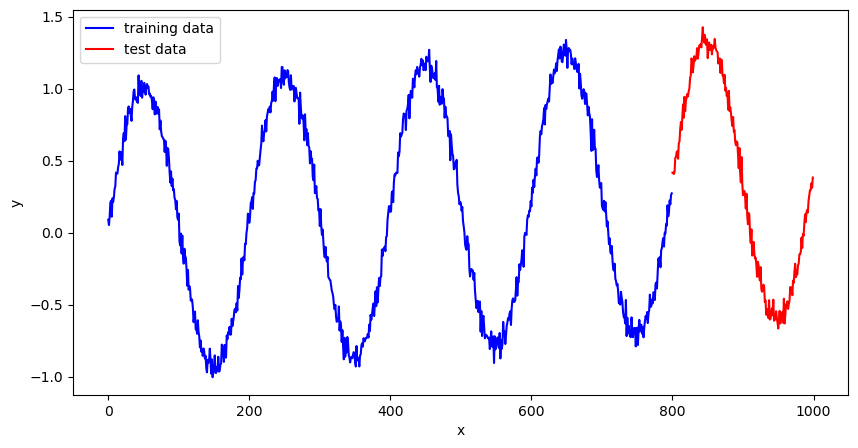

开始训练GRU模型...
GRU Epoch 10/50, Loss: 0.003866
GRU Epoch 20/50, Loss: 0.003766
GRU Epoch 30/50, Loss: 0.003883
GRU Epoch 40/50, Loss: 0.003606
GRU Epoch 50/50, Loss: 0.004074

开始训练MLP模型...
MLP Epoch 10/50, Loss: 0.003588
MLP Epoch 20/50, Loss: 0.003216
MLP Epoch 30/50, Loss: 0.003040
MLP Epoch 40/50, Loss: 0.003080
MLP Epoch 50/50, Loss: 0.002967


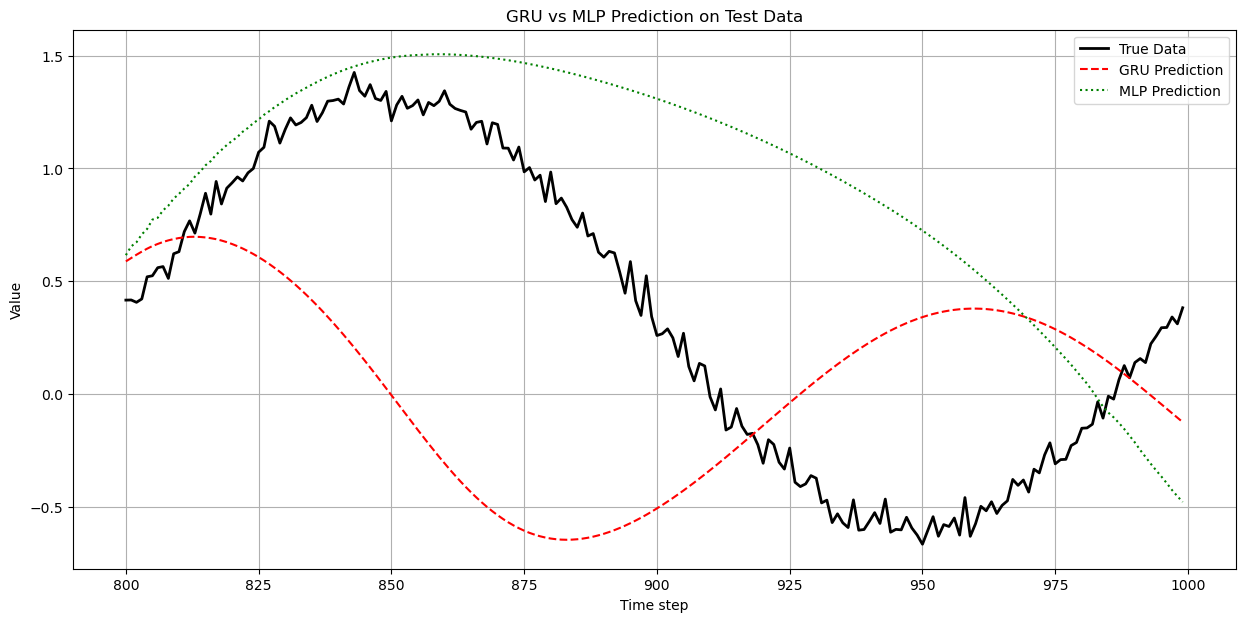

In [7]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 导入数据集
data = np.loadtxt('sindata_1000.csv', delimiter=',')
num_data = len(data)
split = int(num_data * 0.8)
print("数据集大小:", num_data)
print("训练集大小:", split)
plt.figure(figsize=(10, 5))
plt.plot(np.arange(split), data[:split], color='blue', label='training data')
plt.plot(np.arange(split, num_data), data[split:], color='red', label='test data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 分割数据集
train_data = data[:split]
test_data = data[split:]

# --- 修正数据准备逻辑 ---
seq_length = 20

def create_sequences(input_data, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:(i + seq_length)]
        y = input_data[i + seq_length]  # 目标是预测下一个点
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# 设置随机数种子
np.random.seed(0)
torch.manual_seed(0)

# 数据转化为张量并增加特征维度
x_train = torch.from_numpy(x_train).to(torch.float32).unsqueeze(-1) # (N, seq_len, 1)
y_train = torch.from_numpy(y_train).to(torch.float32).unsqueeze(-1) # (N, 1)
x_test = torch.from_numpy(x_test).to(torch.float32).unsqueeze(-1)
y_test = torch.from_numpy(y_test).to(torch.float32).unsqueeze(-1)

# 定义GRU模型
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.linear(out[:, -1, :]) # 只取最后一个时间步的输出
        return out, hidden

# 设置超参数
input_size = 1
output_size = 1
hidden_size = 64
num_layers = 2 # 使用多层GRU
learning_rate = 1e-3
batch_size = 16
num_epochs = 50

# 创建DataLoader
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# 初始化网络
gru = GRU(input_size, output_size, hidden_size, num_layers)
gru_optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# 训练GRU模型
print("开始训练GRU模型...")
for epoch in range(num_epochs):
    gru.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        hidden = None # 每个batch重新初始化hidden
        output, hidden = gru(x_batch, hidden)
        loss = loss_fn(output, y_batch)
        
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()
        
        total_loss += loss.item()
        
    if (epoch + 1) % 10 == 0:
        print(f"GRU Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}")

# 对比测试 MLP模型
mlp = nn.Sequential(
    nn.Linear(seq_length, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size // 2),
    nn.ReLU(),
    nn.Linear(hidden_size // 2, output_size)
)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# 训练MLP模型
print("\n开始训练MLP模型...")
# MLP的输入需要是2D的
x_train_mlp = x_train.squeeze(-1)
y_train_mlp = y_train
mlp_train_dataset = TensorDataset(x_train_mlp, y_train_mlp)
mlp_train_loader = DataLoader(mlp_train_dataset, shuffle=True, batch_size=batch_size)

for epoch in range(num_epochs):
    mlp.train()
    total_loss = 0
    for x_batch, y_batch in mlp_train_loader:
        output = mlp(x_batch)
        loss = loss_fn(output, y_batch)
        mlp_optimizer.zero_grad()
        loss.backward()
        mlp_optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"MLP Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(mlp_train_loader):.6f}")

# --- 修正测试逻辑 ---
def predict(model, initial_input, num_predictions):
    model.eval()
    predictions = []
    current_input = initial_input.clone() # (1, seq_len, 1) or (1, seq_len)
    with torch.no_grad():
        for _ in range(num_predictions):
            if isinstance(model, GRU):
                pred, _ = model(current_input, None)
                predictions.append(pred.item())
                # 更新输入序列: 移除第一个点，加入预测的点
                next_step = pred.unsqueeze(0) # (1, 1, 1)
                current_input = torch.cat((current_input[:, 1:, :], next_step), dim=1)
            else: # MLP
                pred = model(current_input)
                predictions.append(pred.item())
                next_step = pred
                current_input = torch.cat((current_input[:, 1:], next_step), dim=1)
    return predictions

# 获取初始序列进行预测 - 预测测试数据的长度
num_test_points = len(test_data)
gru_preds = predict(gru, x_train[0].unsqueeze(0), num_test_points)
mlp_preds = predict(mlp, x_train.squeeze(-1)[0].unsqueeze(0), num_test_points)

# 绘制预测结果
plt.figure(figsize=(15, 7))
# 真实测试数据从split点开始
test_time_steps = np.arange(split, num_data)
plt.plot(test_time_steps, data[split:], label='True Data', color='black', linewidth=2)
# 预测数据也从split点开始
plt.plot(test_time_steps, gru_preds, label='GRU Prediction', color='red', linestyle='--')
plt.plot(test_time_steps, mlp_preds, label='MLP Prediction', color='green', linestyle=':')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.legend()
plt.title('GRU vs MLP Prediction on Test Data')
plt.grid(True)
plt.show()